# <font color=orange>**Evrisimsel Sinir Aglari**</font> <font color=gray>**(CNN)**</font>

## <font color=gray>**Veri Toplama**</font> 

In [71]:
import keyboard # Klavye uzerindeki tuslara basarak veri toplamaya yarar 
import uuid # Ekrandan kayşt alabilmeyi saglar
import time # Sure tutmaya yarar
from PIL import Image # Python resim kutuphanesi
from mss import mss # Ekran goruntusu alip .png olarak kaydetmeye yarar

In [ ]:
import keyboard
import uuid
import time
from PIL import Image
from mss import mss

"""
http://www.trex-game.skipser.com/
"""

mon = {"top":490, "left":720, "width":300, "height":140}
sct = mss()

i = 0

def record_screen(record_id, key):
    global i
    
    i += 1
    print("{}: {}".format(key, i))
    img = sct.grab(mon)
    im = Image.frombytes("RGB", img.size, img.rgb)
    im.save("./img/{}_{}_{}.png".format(key, record_id, i))
    
is_exit = False

def exit():
    global is_exit
    is_exit = True
    
keyboard.add_hotkey("esc", exit)

record_id = uuid.uuid4()

while True:
    
    if is_exit: break

    try:
        if keyboard.is_pressed(keyboard.KEY_UP):
            record_screen(record_id, "up")
            time.sleep(0.1)
        elif keyboard.is_pressed(keyboard.KEY_DOWN):
            record_screen(record_id, "down")
            time.sleep(0.1)
        elif keyboard.is_pressed("right"):
            record_screen(record_id, "right")
            time.sleep(0.1)
    except RuntimeError: continue

## <font color=gray>**Modelin Egitilmesi**</font> 

In [1]:
import glob
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
imgs = glob.glob('./img/*.png') 
# *.png -> ismi ne olursa olsun tum png uzantili resimleri imgs'e kaydet demek.

width = 125
height = 50

X = []
Y = []

for img in imgs:
    fileName = os.path.basename(img)
    label = fileName.split('_')[0] 
    im = np.array(Image.open(img).convert('L').resize((width,height)))
    im = im / 255
    X.append(im)
    Y.append(label)
    
    
X = np.array(X)
X = X.reshape(X.shape[0], width, height, 1) #(resim sayisi, genislik,yukseklik,channel yani siyah beyaz yazma)

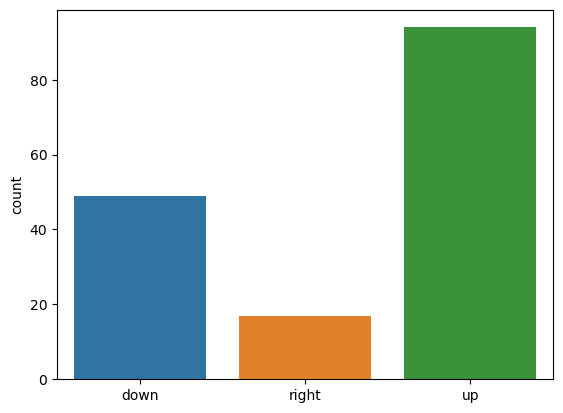

In [3]:
sns.countplot(Y);

In [4]:
# label encoder - one hot encoder

def onehot_labels(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)    
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded),1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [5]:
Y = onehot_labels(Y)

In [6]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, 
                                                    test_size=.25, 
                                                    random_state=2)

In [7]:
# CNN Model

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = (width,height,1)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

'''if os.path.exists('./trex_weight.h5'):
    model.load_weights('trex_weight.h5')
    print('Weights Yuklendi')'''

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.fit(train_X,train_y, epochs=35, batch_size = 64)

score_train = model.evaluate(train_X,train_y)
print('Egitim Dogrulugu: %', score_train[1]*100)

score_test = model.evaluate(test_X,test_y)
print('Test Dogrulugu: %', score_test[1]*100)

Epoch 1/35
2/2 [==============================] - 4s 958ms/step - loss: 3.5911 - accuracy: 0.4333
Epoch 2/35
2/2 [==============================] - 2s 942ms/step - loss: 3.3843 - accuracy: 0.4083
Epoch 3/35
2/2 [==============================] - 2s 979ms/step - loss: 1.2984 - accuracy: 0.4750
Epoch 4/35
2/2 [==============================] - 2s 964ms/step - loss: 0.9329 - accuracy: 0.5667
Epoch 5/35
2/2 [==============================] - 2s 1s/step - loss: 0.7255 - accuracy: 0.6750
Epoch 6/35
2/2 [==============================] - 2s 1s/step - loss: 0.6595 - accuracy: 0.8083
Epoch 7/35
2/2 [==============================] - 2s 1s/step - loss: 0.5725 - accuracy: 0.7833
Epoch 8/35
2/2 [==============================] - 2s 965ms/step - loss: 0.5196 - accuracy: 0.8417
Epoch 9/35
2/2 [==============================] - 2s 1s/step - loss: 0.4650 - accuracy: 0.8583
Epoch 10/35
2/2 [==============================] - 2s 933ms/step - loss: 0.3996 - accuracy: 0.8667
Epoch 11/35
2/2 [==============

In [8]:
# Modeli kaydetmek istersek:

open('model.json','w').write(model.to_json())
model.save_weights('trex_weight.h5')

## <font color=gray>**Modelin Test Edilmesi**</font> 

In [9]:
from keras.models import model_from_json
import numpy as np
from PIL import Image
import keyboard
import time
from mss import mss

In [10]:
# Trex ekraninin pikselleri:
mon = {"top":490, "left":720, "width":300, "height":140}
sct = mss()

width = 125
height = 50

In [12]:
# Modelin Yuklenmesi:

model = model_from_json(open("model.json","r").read())
# Modeli ice aktardik ama ici bos 
model.load_weights("trex_weight.h5")

In [13]:
'''
Etiketler

down = 0
right = 1
up = 2
'''

labels = ["Down", "Right", "Up"]

In [ ]:
framerate_time = time.time()
counter = 0
i = 0
delay = 0.4 #bir tusun basildiktan sonraki bekleme suresi
key_down_pressed = False

while True:
    #ekrandan bir resim alip donusturma islemi
    img = sct.grab(mon)
    im = Image.frombytes("RGB", img.size, img.rgb)
    # Yeniden boyutlama:
    im2 = np.array(im.convert("L").resize((width, height)))
    im2 = im2 / 255
    
    X =np.array([im2])
    X = X.reshape(X.shape[0], width, height, 1)
    r = model.predict(X)
    
    result = np.argmax(r) #argmax icerigin en buyuk olaninin index'ini dondurur
    
    if result == 0: 
        keyboard.press(keyboard.KEY_DOWN) # Asagi butonuna bas
        key_down_pressed = True # Asagi butonuna bastim demek
        
    elif result == 2:
        
        if key_down_pressed:
            keyboard.release(keyboard.KEY_DOWN)
        time.sleep(delay)    
        keyboard.press(keyboard.KEY_UP)
        
        if  i<1500: #Oyun 1500.u frame'e kadar normal akiyor. sonra hizlaniyor.
            time.sleep(0.3)
            
        elif 1500 < i and i < 5000:
            time.sleep(0.2)
        else:
            time.sleep(0.17)
        #havadaki durumdan asagi gecmek icin:
        keyboard.press(keyboard.KEY_DOWN) # Asagi tusuna bas
        keyboard.release(keyboard.KEY_DOWN) # Asagi tusuna basmayi birak
   
    counter += 1
    
    if (time.time() - framerate_time) > 1:
        
        counter = 0
        framerate_time = time.time()
        if i <= 1500:
            delay -= 0.003
        else:
            delay -= 0.005
        if delay < 0:
            delay = 0
            
            
        print("---------------------")
        print("Down: {} \nRight:{} \nUp: {} \n".format(r[0][0],r[0][1],r[0][2]))
        i += 1